In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer

In [2]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(12, 8)})

In [3]:
!ls

EDA.ipynb                 assignment_data_train.csv
assignment_data_test.csv  assignment_details.pdf


In [4]:
train = pd.read_csv('assignment_data_train.csv')

In [5]:
train.shape

(14037, 3)

In [6]:
train.head()

,EVENT_TYPE,comment,EVENT_ID
0,PROMISE_TO_PAY,PROMISE TO PAY BY CASH ON 21 NOV 2018,9346
1,RINGING,RNG.,10430
2,NOT_CONTACTABLE,ASSIGNED TO AGENCY AG ENTERPRISES,21762
3,PAID,PAID,19014
4,PROMISE_TO_PAY,PTP GIVEN BY CUSTOMER TO AGENCY,10400


In [7]:
train.EVENT_TYPE.unique()

array(['PROMISE_TO_PAY', 'RINGING', 'NOT_CONTACTABLE', 'PAID',
       'CASH_PICK_UP', 'FOLLOW_UP', 'NOT_WILLING_TO_PAY'], dtype=object)

## EDA Objective

We are trying the read the comment and predict what event type probably occured. This is important to automatically initiate some actions further into the business. The objective of the following EDA is to find some hidden insights that can ease us understanding the dataset.

### Distribution of differnet event type

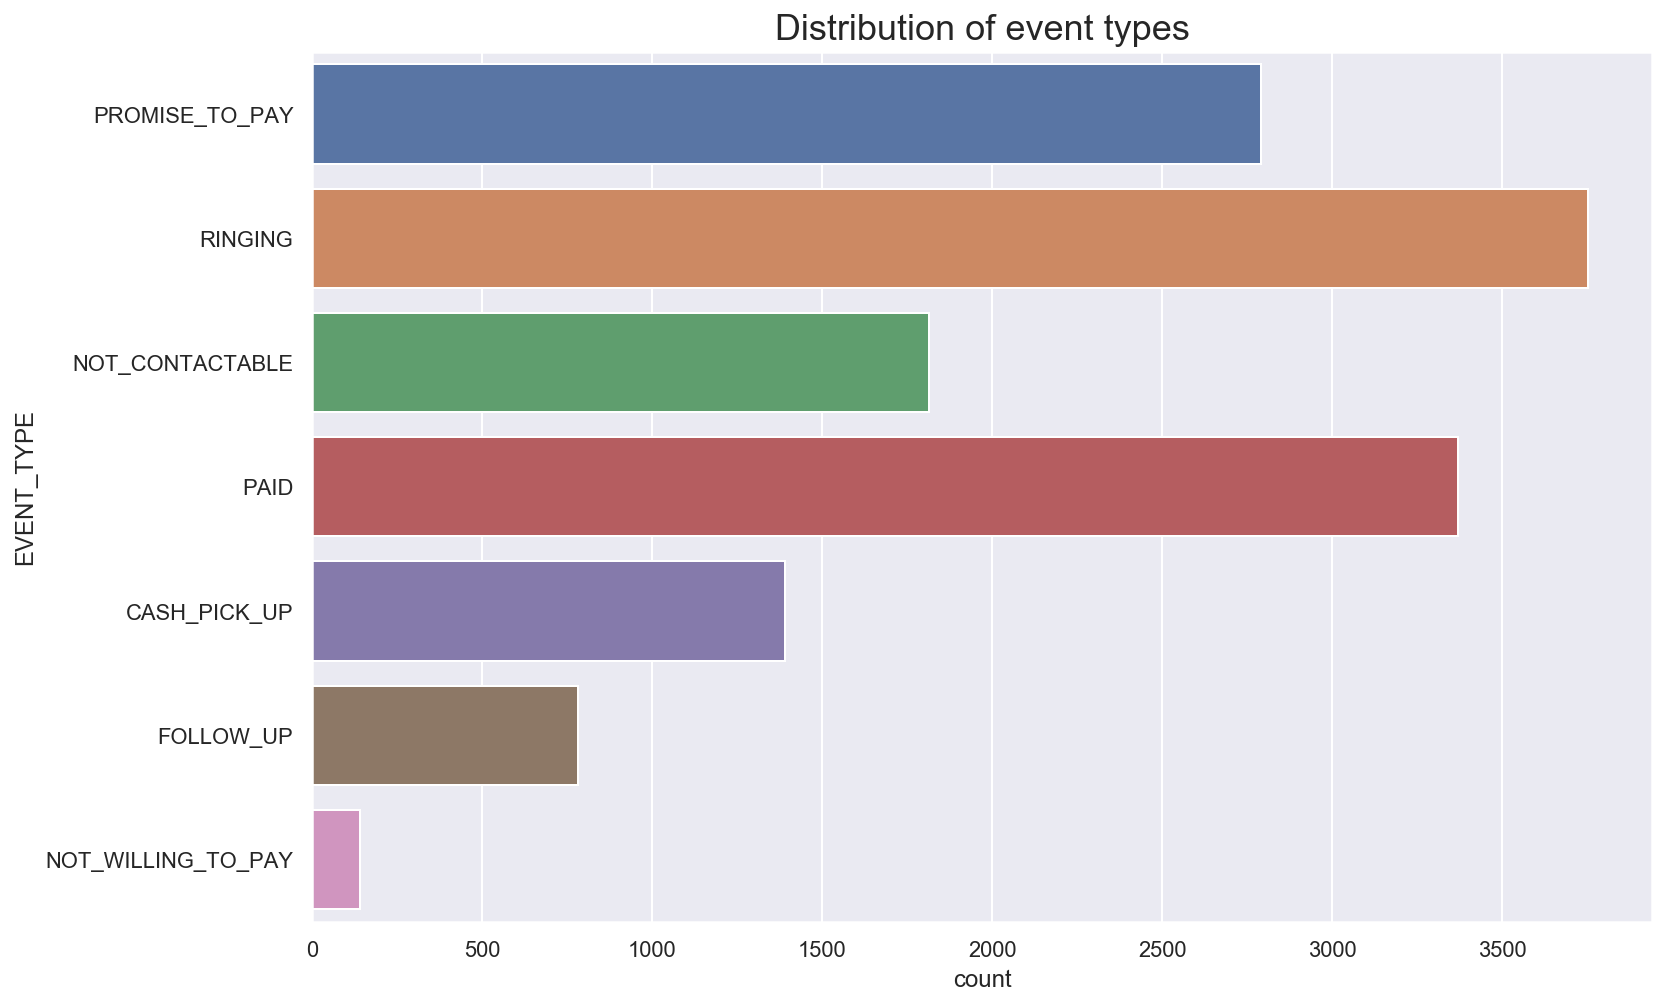

In [8]:
sns.countplot(y=train.EVENT_TYPE);
plt.title('Distribution of event types', fontsize=18);

### Model Conclusions

- The dataset for some class labels is baised
- Most of the time `paid` or `promised_to_pay` or `ringing` is the class label and hence creating a baseliner won't be any issue
- Very few people are not willing to pay which can cause problem during model building and hence we should use `multi-class logloss` as evalutaion metrics

### What makes people not willing to pay?

This insight is important because this is the class label with least distribution which means if we can get good understanding of this case, we can get good log-loss

In [9]:
not_pay = train[train.EVENT_TYPE == 'NOT_WILLING_TO_PAY']

In [10]:
not_pay.shape

(139, 3)

In [35]:
freq = defaultdict(int)
tokenizer = RegexpTokenizer(r'\w+')

In [40]:
not_pay.comment.values[0]

'ONE EMI GIVEN TO VINAYAK (SALES EXECUTIVE ) THATS Y CUSTOMER NOT GIVEN THAT EMI'

In [41]:
for each in not_pay.comment.values:
    for token in tokenizer.tokenize(each):
        freq[token] += 1

In [44]:
# corpus = " ".join(not_pay.comment.values.tolist())

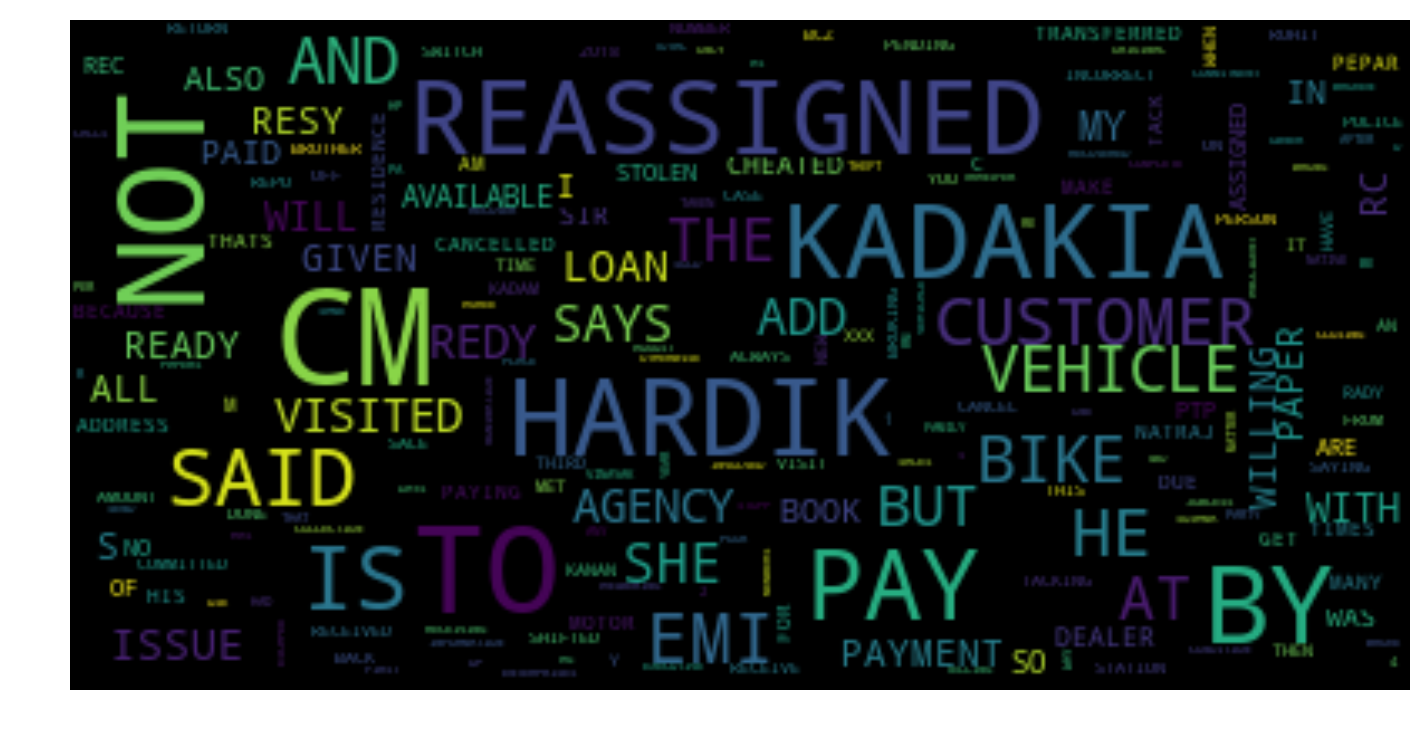

In [47]:
## Code Courtesy: WordCloud Documentation
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Model Conclusion

- `HARDIK KADAKIA` seems very highly related that can be used to create a feature as a step for feature engineering
- Some other words indivisually doesn't seem to mean a lot but with conjunction seems meaningful. This gives the idea that `n-grams` can be useful upto 2 or 3
- `REASSIGNED` seems another word but the meaning for the word seems very generic and more domain knowledge is required for this.

## Are `PAID` events self explanatory?

In [48]:
paid = train[train.EVENT_TYPE == 'PAID']

In [51]:
freq = defaultdict(int)
tokenizer = RegexpTokenizer(r'\w+')
for each in paid.comment.values:
    for token in tokenizer.tokenize(each):
        freq[token] += 1

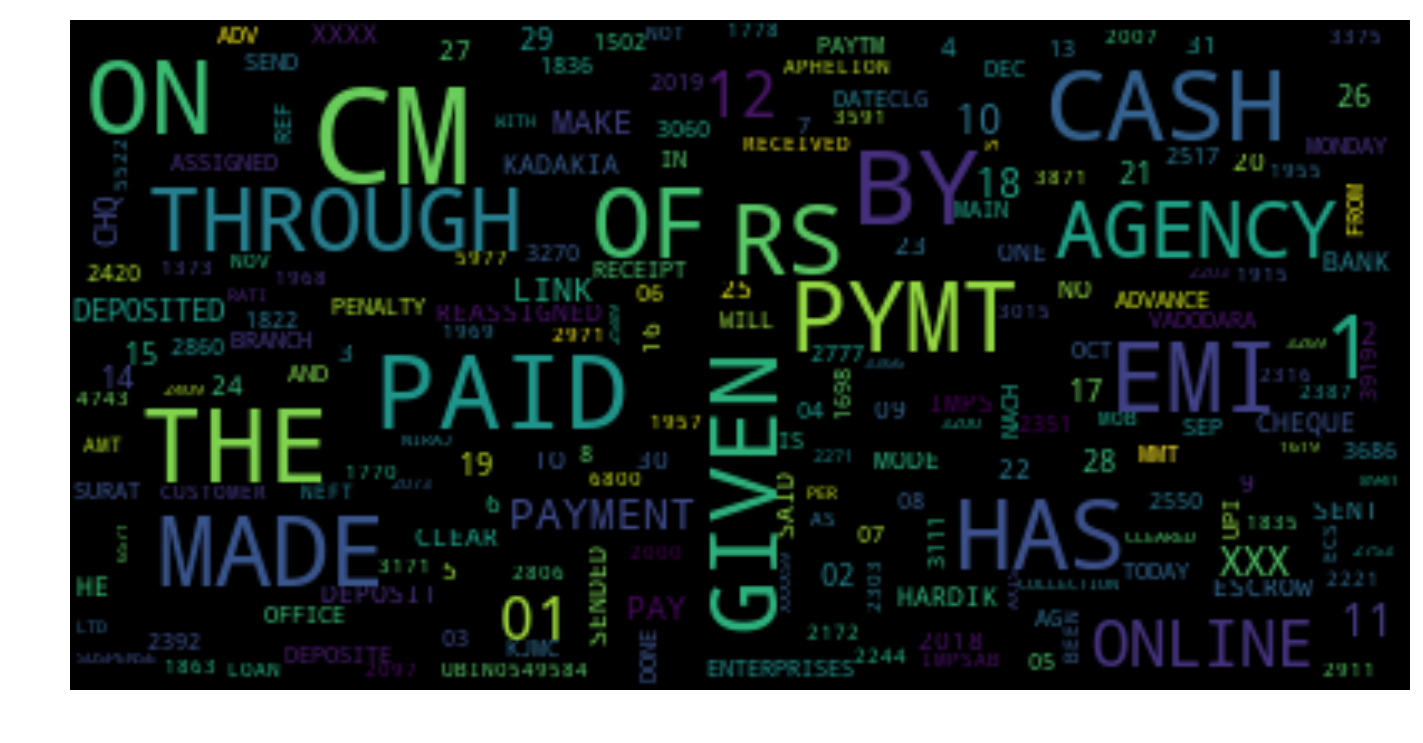

In [52]:
## Code Courtesy: WordCloud Documentation
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Conclusion

- Yes I was right!! These are some of the most common words that are used to represent the status if the payment has been made. This means simple `CountVectorizer` would be appropriate to featurize the text data.
- Again we see some words occuring in conjunction with each other. This is a strong indication of bigrams or even trigrams

### How different `RINGING` and `NOT_CONTACTABLE` are? 

In [59]:
ring = train[train.EVENT_TYPE == 'RINGING']
nc = train[train.EVENT_TYPE == 'NOT_CONTACTABLE']

In [61]:
tokenizer = RegexpTokenizer(r'\w+')

In [62]:
freq1 = defaultdict(int)
freq2 = defaultdict(int)

for each in ring.comment.values:
    for token in tokenizer.tokenize(each):
        freq1[token] += 1
for each in nc.comment.values:
    for token in tokenizer.tokenize(each):
        freq2[token] += 1

In [64]:
wordcloud1 = WordCloud(max_font_size=40).generate_from_frequencies(freq1)
wordcloud2 = WordCloud(max_font_size=40).generate_from_frequencies(freq2)

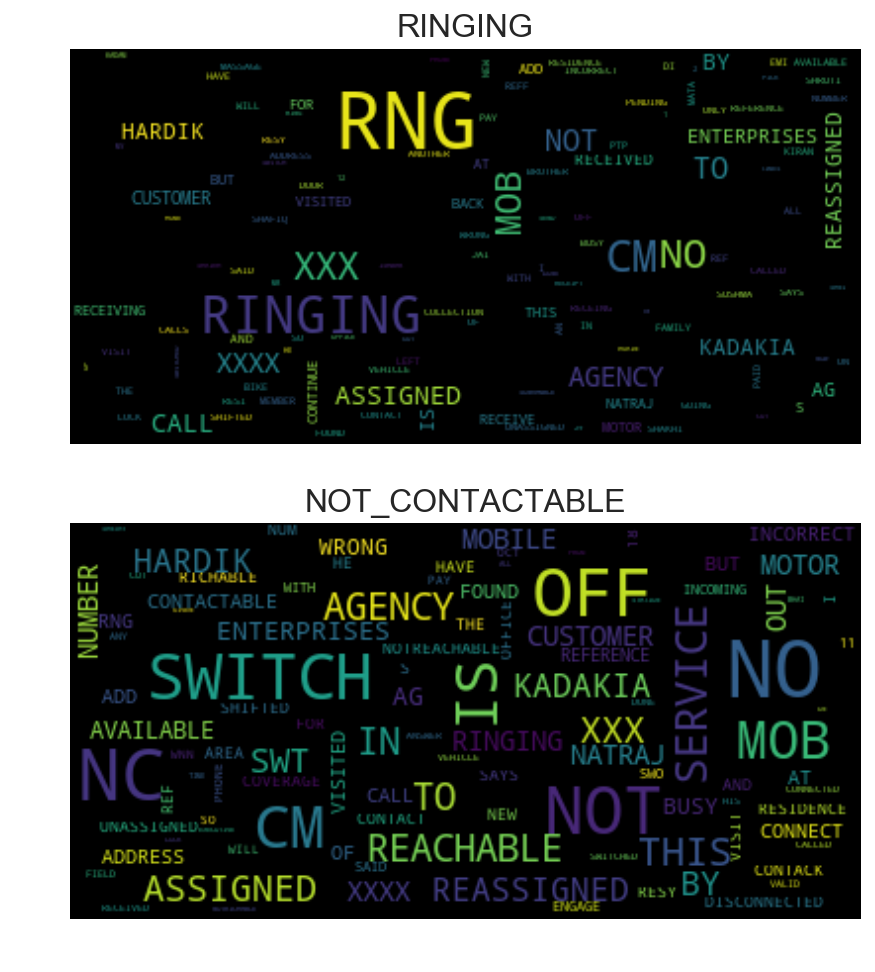

In [70]:
plt.subplot(211)
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.title('RINGING', fontsize=16)
plt.subplot(212)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title('NOT_CONTACTABLE', fontsize=16)
plt.show()

- `RINGING` is an easy case as it seems from the wordcloud
- `NOT_CONTACTABLE` is something that makes sense to but however `RINGING` and `NOT_CONTACTABLE` could have been merged.
- Again **HARDIK** and **KADAKIA** seems to be in the `NOT_CONTACTABLE` list. Seems that they are closely related to defaulters.

## Does `HARDIK` and `KADAKIA` makes the most of non-payment category?

In [80]:
def count_freq(df, w):
    count = 0
    for each in df.comment.values:
        for word in tokenizer.tokenize(each):
            if word.upper() == w:
                count += 1
    return count

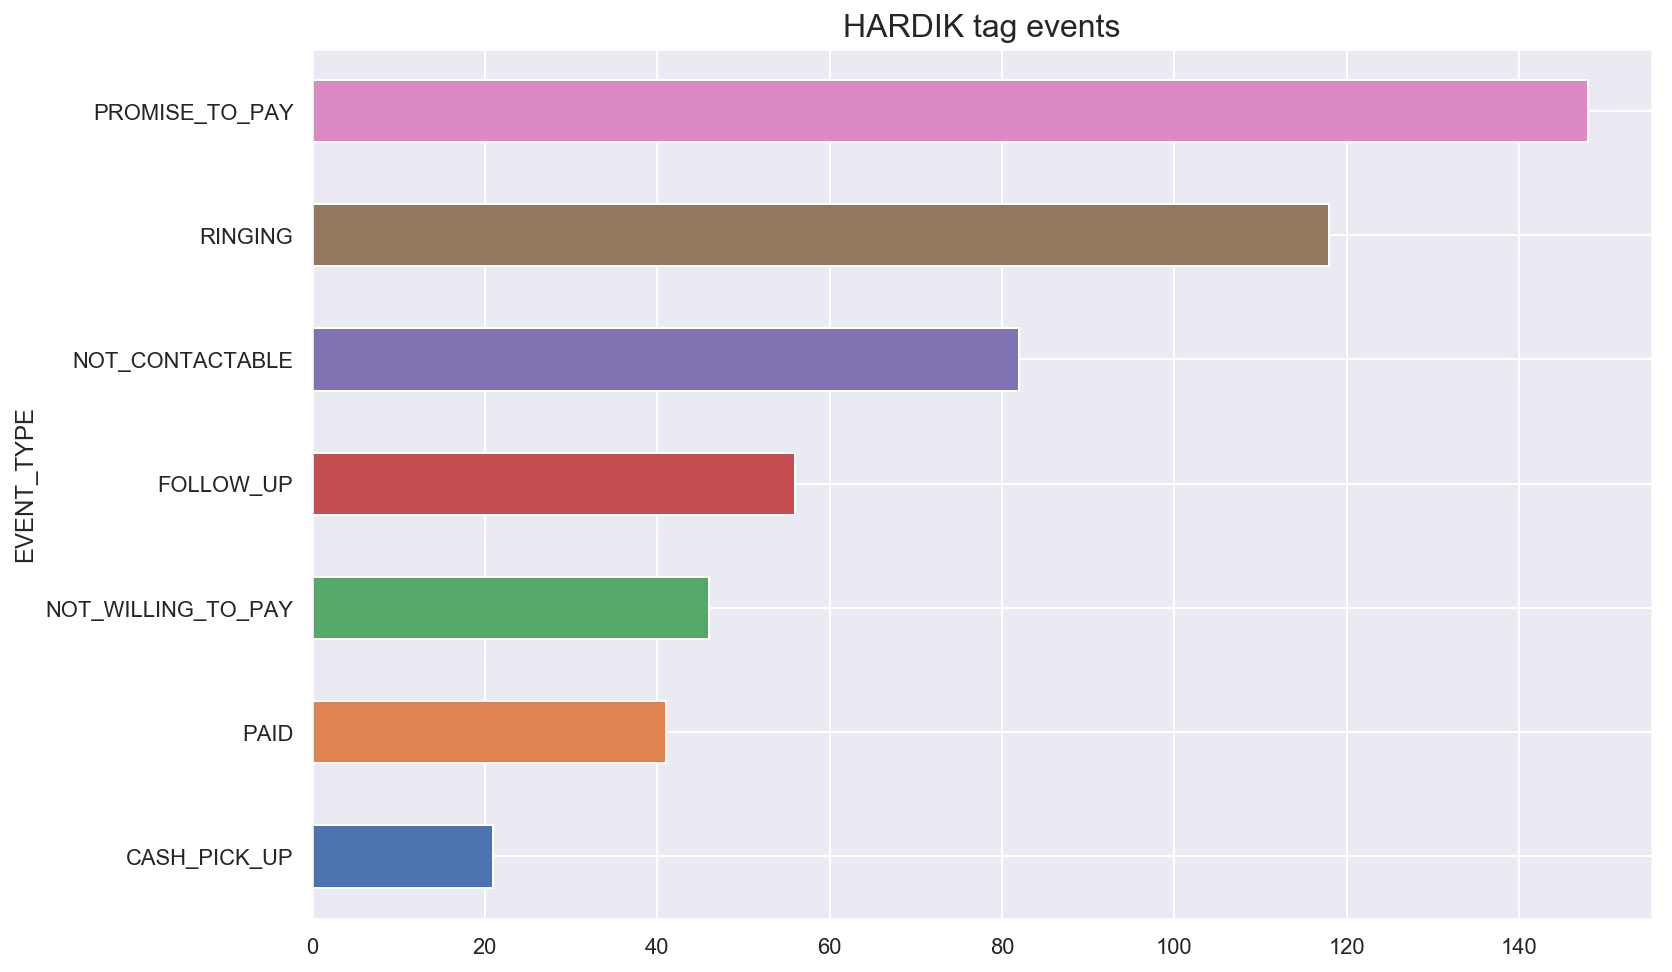

In [89]:
h = train.groupby('EVENT_TYPE').apply(lambda x: count_freq(x, 'HARDIK'))
h.sort_values().plot(kind='barh');
plt.title('HARDIK tag events', fontsize=16);

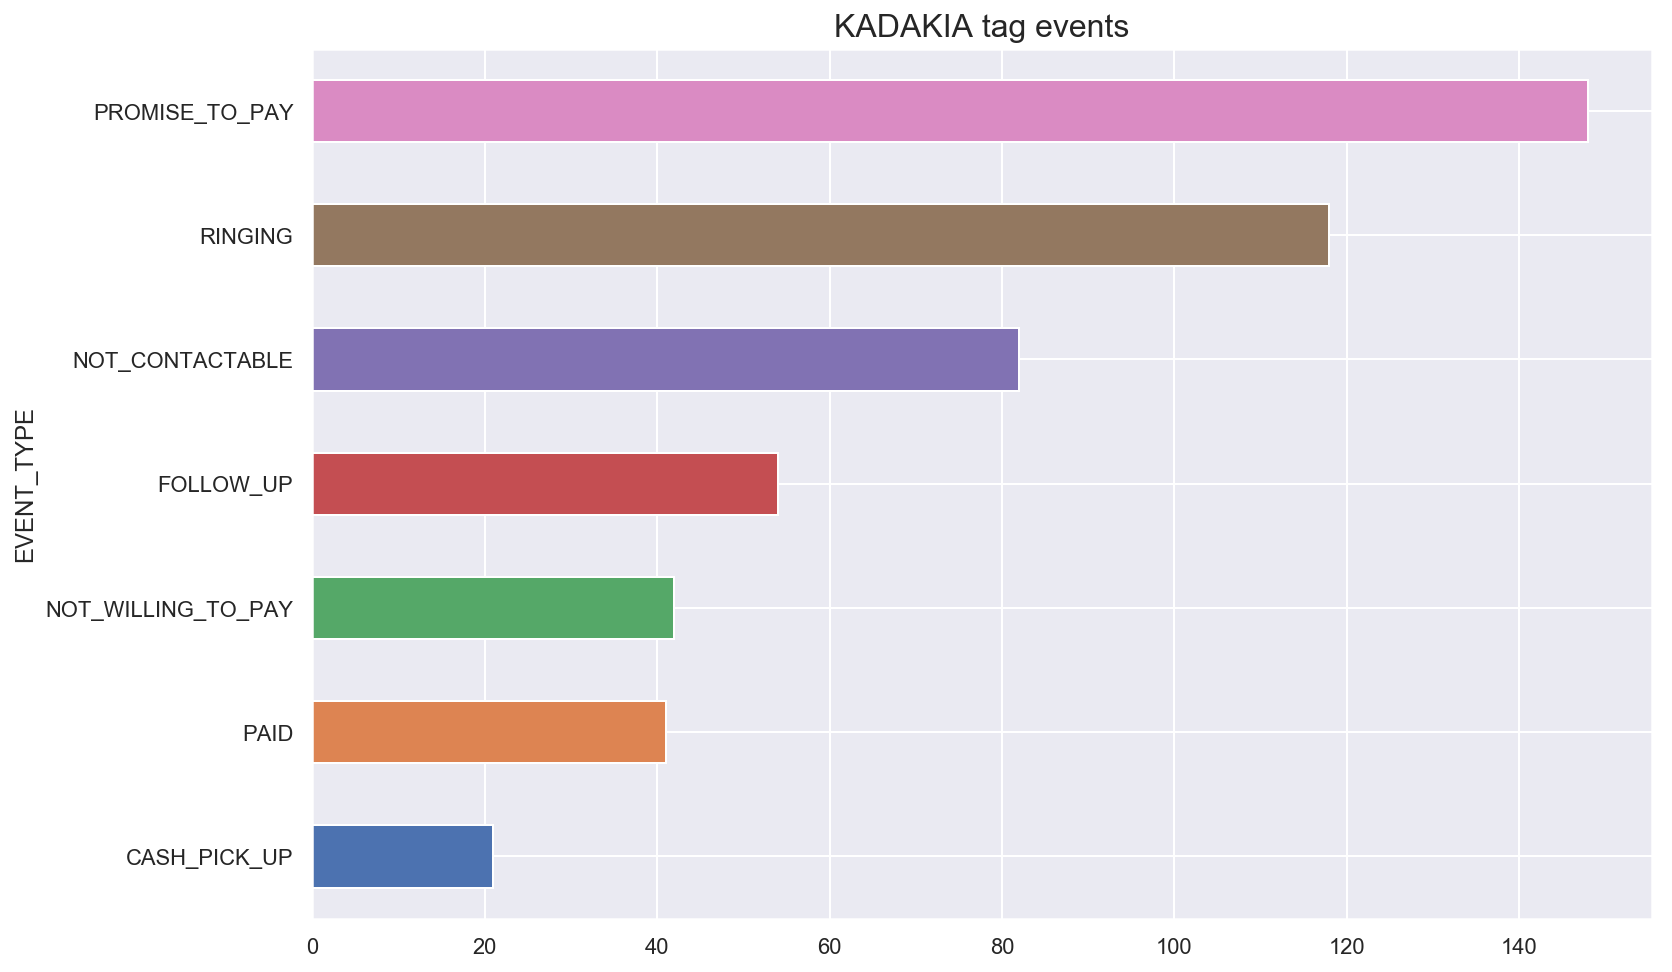

In [91]:
h = train.groupby('EVENT_TYPE').apply(lambda x: count_freq(x, 'KADAKIA'))
h.sort_values().plot(kind='barh');
plt.title('KADAKIA tag events', fontsize=16);

### There is some confusion in labels for `RINGING` for sure

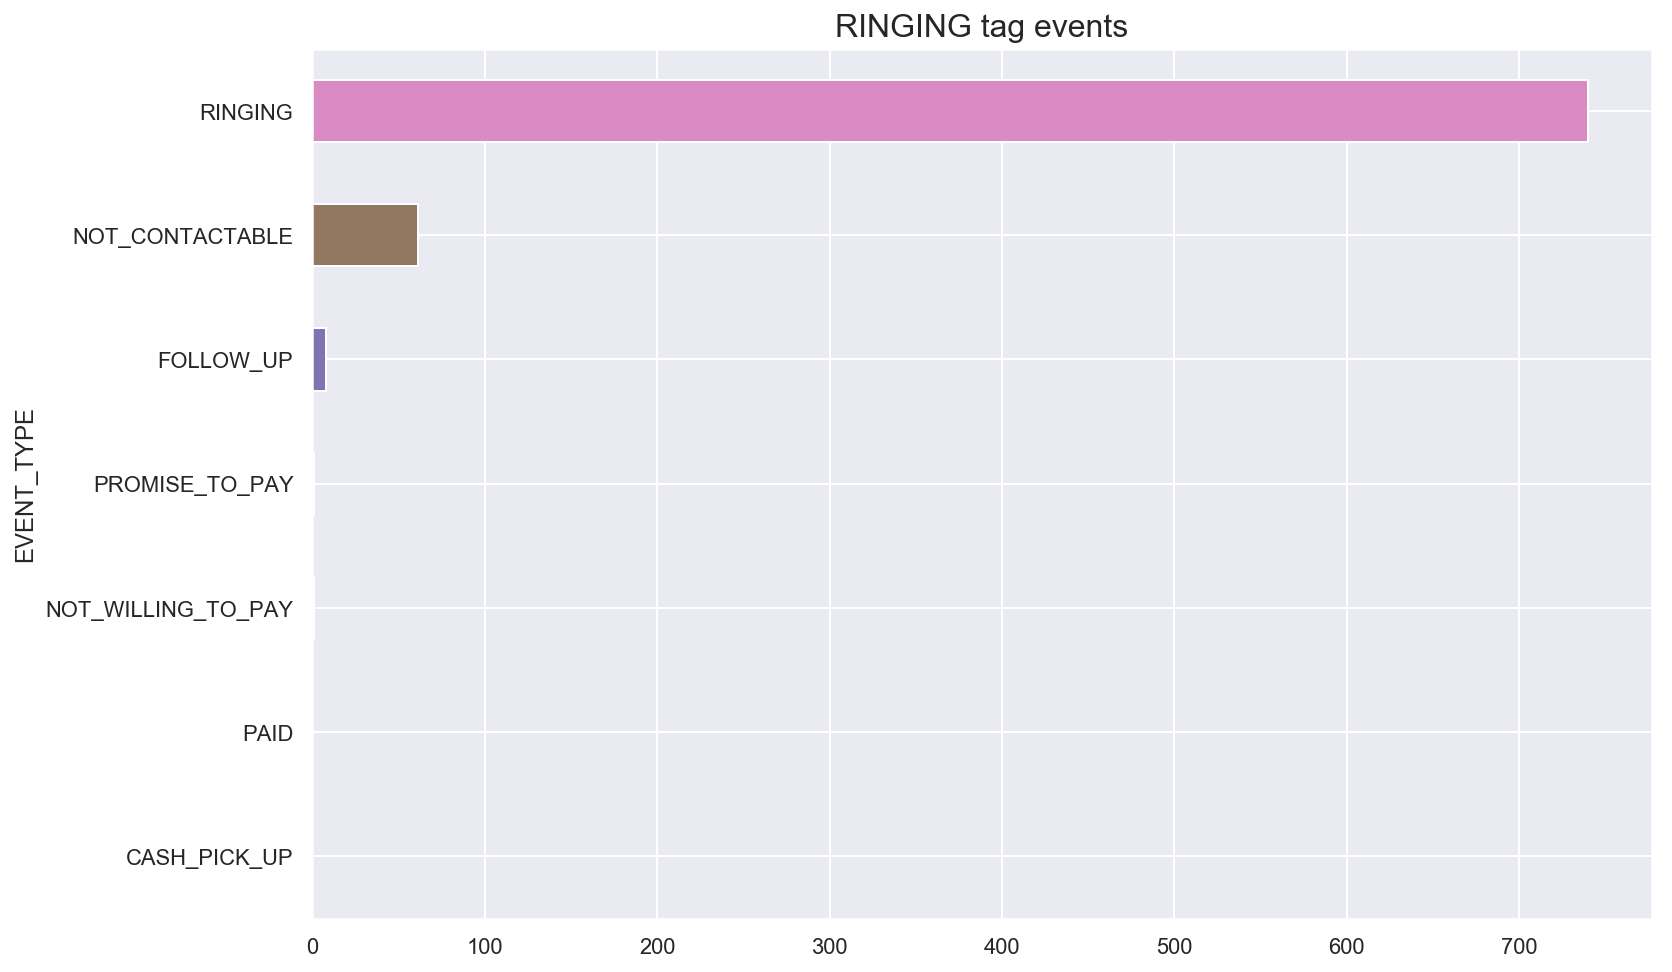

In [93]:
h = train.groupby('EVENT_TYPE').apply(lambda x: count_freq(x, 'RINGING'))
h.sort_values().plot(kind='barh');
plt.title('RINGING tag events', fontsize=16);

### In many cases, Comment and EVENT_TYPE is same?